In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In [10]:
def get_dataset(data_set_path): 
    return pd.read_csv(data_set_path, sep=',')

drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_smiles.csv")
metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/preprocessed_metxbiodb/smiles_metxbiodb.csv")

cleaned_drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_clean.csv")
cleaned_metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/preprocessed_metxbiodb/metxbiodb_clean.csv")

unique_drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_clean_unique_parents.csv")
unique_metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/preprocessed_metxbiodb/metxbiodb_clean_unique_parents.csv")

In [6]:
def create_pychart(data, labels): 
    colors = ['#b7ded2', '#f6a6b2', '#f7c297', '#90d2d8']
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})

def get_duplicates_from_datasets(dataset_first, dataset_second):
    equal_count = 0
    for i, row_db in dataset_first.iterrows():
        parent = row_db['parent_smiles']
        child = row_db['child_smiles']

        duplicated = dataset_second[(dataset_second["parent_smiles"] == parent) & (dataset_second["child_smiles"] == child)]

        if not duplicated.empty: 
            equal_count += 1 
            
    return equal_count

def data_source_analysis(dataset_first, dataset_first_name, dataset_second, dataset_second_name): 
    dataset_first = dataset_first[['parent_smiles', 'child_smiles']]
    dataset_second = dataset_second[['parent_smiles', 'child_smiles']]
    duplicate_count = get_duplicates_from_datasets(dataset_first, dataset_second)

    first_dataset_length = len(dataset_first) - duplicate_count
    second_dataset_length = len(dataset_second) - duplicate_count

    labels = [dataset_first_name, dataset_second_name]
    data = [first_dataset_length, second_dataset_length]
    
    if duplicate_count > 0: 
        print(f"Duplicates {duplicate_count}")
        data.append(duplicate_count)
        labels.append(f"{dataset_first_name} and {dataset_second_name}")
    
    total_dataset_length = first_dataset_length + second_dataset_length + duplicate_count
    print('Total: ', total_dataset_length)
    create_pychart(data, labels)

Duplicates 32
Total:  3397


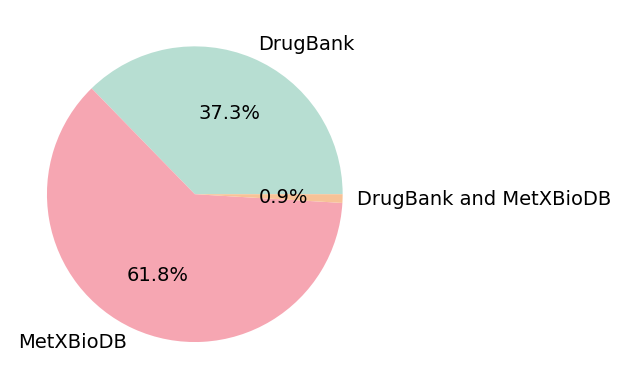

In [8]:
data_source_analysis(drugbank, 'DrugBank', metxbiodb, 'MetXBioDB')

Duplicates 65
Total:  3364


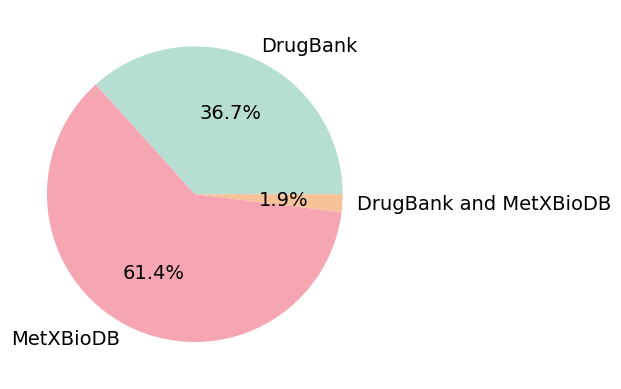

In [9]:
data_source_analysis(cleaned_drugbank, 'DrugBank', cleaned_metxbiodb, 'MetXBioDB')

Duplicates 25
Total:  1913


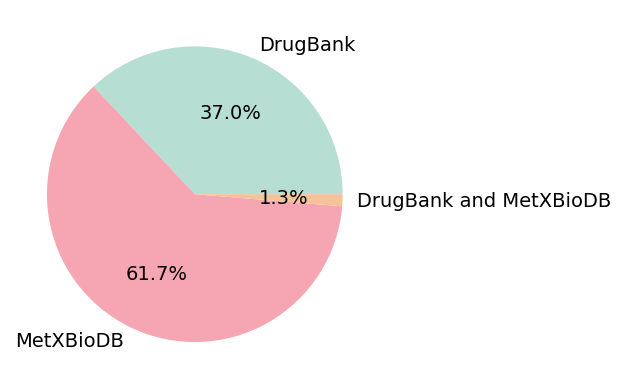

In [11]:
data_source_analysis(unique_drugbank, 'DrugBank', unique_metxbiodb, 'MetXBioDB')

In [18]:
def finger_print_similarity(dataset):
    parent_smiles = dataset['parent_smiles'].tolist()
    metabolite_smiles = dataset['child_smiles'].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    parent_fps = [Chem.RDKFingerprint(x) for x in parent_mol]
    metabolite_fps = [Chem.RDKFingerprint(x) for x in metabolite_mol]

    # parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    # metabolite_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in metabolite_mol]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        
        s = DataStructs.TanimotoSimilarity(parent_fps[i],metabolite_fps[i]) 
        fingerprint_similarities.append(s)

    return fingerprint_similarities  

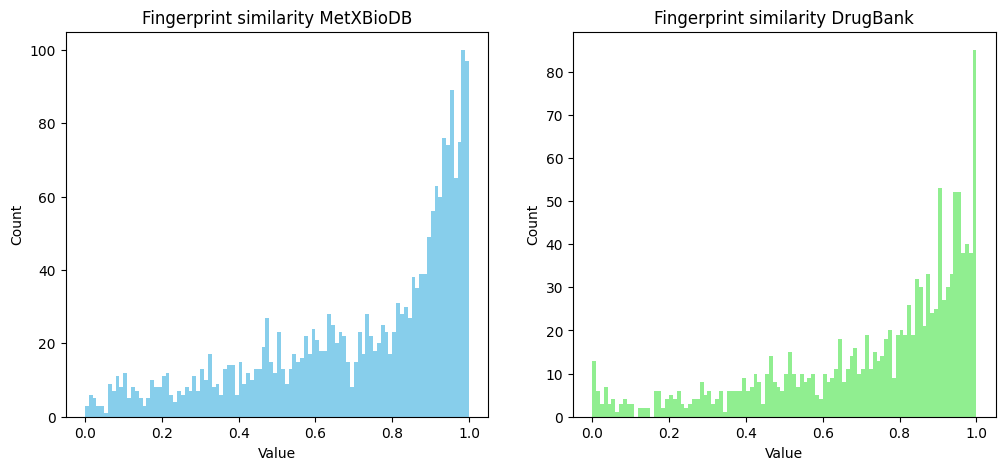

In [20]:
metxbiodb_similarities = finger_print_similarity(metxbiodb)
drugbank_similarities = finger_print_similarity(drugbank)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(metxbiodb_similarities, bins=100, color='skyblue')
ax[0].set_title('Fingerprint similarity MetXBioDB')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')

ax[1].hist(drugbank_similarities, bins=100, color='lightgreen')
ax[1].set_title('Fingerprint similarity DrugBank')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')

plt.show()